In [1]:
!nvidia-smi

Thu Nov 21 21:55:39 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K40m          Off  | 00000000:0B:00.0 Off |                    0 |
| N/A   35C    P0    67W / 235W |      0MiB / 11441MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
torch.cuda.is_available()

True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import DistilBertTokenizer, DistilBertModel
import torch.nn.functional as F
warnings.filterwarnings('ignore')

###**Data Preparation**

In [4]:
# import the training data # using testing data (400k rows) for training 
df = pd.read_csv('amazon_reviews_test.csv')
df.head()

,label,text
0,1,Great CD: My lovely Pat has one of the GREAT v...
1,1,One of the best game music soundtracks - for a...
2,0,Batteries died within a year ...: I bought thi...
3,1,"works fine, but Maha Energy is better: Check o..."
4,1,Great for the non-audiophile: Reviewed quite a...


In [5]:
# import testing data # Using training data (3.6 million rows) for testing
test = pd.read_csv('amazon_reviews_train.csv')

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   400000 non-null  int64 
 1   text    400000 non-null  object
dtypes: int64(1), object(1)
memory usage: 6.1+ MB


In [81]:
# value count
df.label.value_counts()

label
1    200000
0    200000
Name: count, dtype: int64

In [7]:
#load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

### checking max lenght of sentance 

In [91]:
# calculate sentence lenght 
token_len=[len(sentence.split()) for sentence in df['text']]

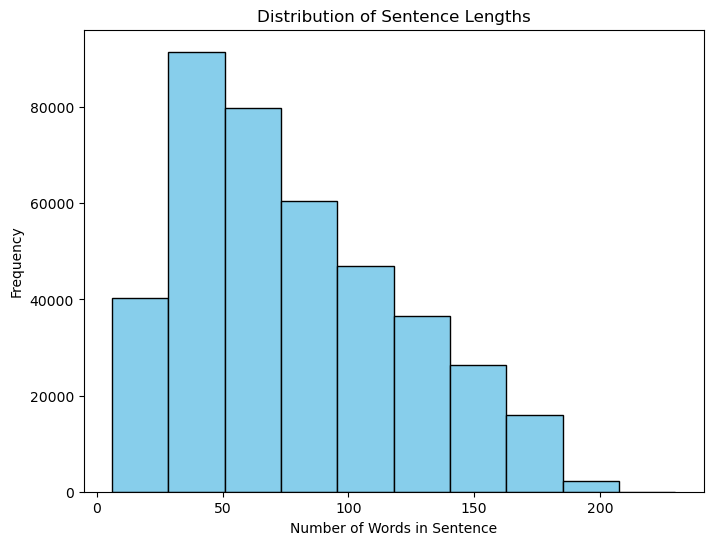

In [94]:
# plot the distribution of sentence length
plt.figure(figsize=(8, 6))
plt.hist(token_len, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Number of Words in Sentence')
plt.ylabel('Frequency')
plt.show()


## max num of words are around 200 so max length can be 256

### **Create Pytorch Dataset and Dataloader**

In [10]:
class AmazonReviewsDataset(torch.utils.data.Dataset):
  def __init__(self, df):
    self.df = df
    self.maxlen = 256
    self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    review = str(self.df['text'].iloc[index])
    target = self.df['label'].iloc[index]

    encodings = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True, # adding [SEP], [PAD],... tokens
        max_length=self.maxlen,  
        padding='max_length',  # paddding last remaining tokens
        truncation=True,       # if a sample has more than 256 tokens, remove them
        return_attention_mask=True,
        return_tensors='pt'
    )

    return {
        'input_ids': encodings.input_ids.flatten(),
        'attention_mask': encodings.attention_mask.flatten(),
        'labels': torch.tensor(target, dtype=torch.long)
    }

In [11]:
## train test split
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
len(train_df), len(test_df)

(280000, 120000)

In [28]:
train_dataset = AmazonReviewsDataset(train_df)
valid_dataset = AmazonReviewsDataset(test_df)

In [29]:
# train and test loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=32
)

In [30]:
for batch in train_loader:
  print(batch['input_ids'].shape)
  print(batch['attention_mask'].shape)
  print(batch['labels'].shape)
  break

torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32])


### **Model Creation**

In [14]:
class SentimentClassifier(nn.Module):
    def __init__(self):
        super(SentimentClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased', num_labels = 2) #binary classification
        self.dropout = nn.Dropout(p=0.3) # dropout layer
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)  # Classification layer
        # self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_ids, attention_mask):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        last_hidden_state = output.last_hidden_state
        cls_embedding = last_hidden_state[:, 0, :]  # use the [CLS] token's embedding
        cls_embedding = self.dropout(cls_embedding)
        logits = self.classifier(cls_embedding)  # pass through classification layer
        return logits
    
        # return self.softmax(output)

In [33]:
model = SentimentClassifier() # initializing model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)   # load model to cuda

SentimentClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Lin

In [34]:
# Example to test the forward pass
sample_text = "so Bad."
encoding = tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True,
    max_length=256,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

input_ids = encoding['input_ids'].to('cuda')
attention_mask = encoding['attention_mask'].to('cuda')

# Make predictions
with torch.no_grad():
    logits = model(input_ids=input_ids, attention_mask=attention_mask)

print(logits)
# Convert logits to probabilities and get the predicted sentiment
probabilities = torch.softmax(logits, dim=1)
print(probabilities)
predicted_label = torch.argmax(probabilities).item()

print(f"Predicted Sentiment: {predicted_label} (1=Positive, 0=Negative)")

tensor([[0.3346, 0.1107]], device='cuda:0')
tensor([[0.5558, 0.4442]], device='cuda:0')
Predicted Sentiment: 0 (1=Positive, 0=Negative)


- We can see that model is not predicting right sentiment

###**Train Loop**

In [37]:

criterion = nn.CrossEntropyLoss().to(device) # loss function
optimizer = optim.AdamW(model.parameters(), lr=2e-5) #optimizer
epochs = 3 # epochs

In [38]:
#trining loop
for epoch in range(epochs):
  # TRAIN
  model.train()
  train_loop = tqdm(train_loader)
    
  for batch in train_loop:
    optimizer.zero_grad()
      
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
      
    output = model(input_ids, attention_mask)
    loss = criterion(output, labels)
    loss.backward()
    # nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    train_loop.set_description(f"Training Epoch: {epoch}")
    train_loop.set_postfix(loss=loss.item())

  # VALIDATION
  model.eval()
  valid_loop = tqdm(valid_loader)
    
  for batch in valid_loop:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    output = model(input_ids, attention_mask)
    loss = criterion(output, labels)

    valid_loop.set_description(f"Validation Epoch: {epoch}")
    valid_loop.set_postfix(loss=loss.item())

  0%|          | 0/8750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/8750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/8750 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/3750 [00:00<?, ?it/s]

In [75]:
# save the model
torch.save(model, './sentiment_model.pth')

In [16]:
# set device as cuda
device = 'cuda'

In [23]:
# test on any example
test_sample = test['text'].iloc[211]
original_label = test['label'].iloc[211]

print(f"Review:\n {test_sample}\n")
print(f"Original Sentiment:- {'Negative' if original_label == 0 else 'Positive'}\n")

encodings = tokenizer.encode_plus(
    test_sample,
    add_special_tokens=True,
    max_length=256,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

with torch.no_grad():
    preds = model(encodings['input_ids'].to(device), encodings['attention_mask'].to(device))
    # softmex
    preds = torch.softmax(preds, dim=1)
    # argmax
    preds = torch.argmax(preds).item()
    print(f"Predicted Sentiment:- {'Negative' if preds == 0 else 'Positive'}\n")
  

Review:
 Great control racquet: A great racquet for anyone, although it is better suited for the more advanced player. For years, I played with the OS version of this racquet which is noticeably more powerful and is a little more forgiving than the MS version. At this point, I prefer the MS version more just because of the better control and feel.Even now, the Prince Graphite (OS or MS) is still a great racquet, and IMO, one of the best control racquets ever made.

Original Sentiment:- Positive

Predicted Sentiment:- Positive



In [32]:
# initialize lists
true_labels = []
predictions = []

# loop over the test dataset
for i in range(len(test)):
    test_sample = test['text'].iloc[i]
    original_label = test['label'].iloc[i]
    
    # store the true label
    true_labels.append(original_label)
    
    # encode the test sample
    encodings = tokenizer.encode_plus(
        test_sample,
        add_special_tokens=True,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    ).to(device)
    
    # get model predictions 
    with torch.no_grad():
        preds = model(encodings['input_ids'], encodings['attention_mask']).to(device)
        preds = torch.softmax(preds, dim=1)
        preds = torch.argmax(preds, dim=1).item()  # Get the predicted label
    
    # store the predicted label
    predictions.append(preds)

In [33]:
# calculate accuracy
accuracy = classification_report(true_labels, predictions)
print(accuracy)


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1035
           1       0.96      0.95      0.96       965

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000

